# Project 2 Ames Housing



## Import libraries

In [16]:
# Imports:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

from scipy import stats
import statsmodels.api as sm

from itertools import combinations

%matplotlib inline

# Set the graph style
sns.set_style('whitegrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [7]:
# Set relative data path
data_path = "../datasets"
test_dataframe_name = "test_clean.csv"
train_dataframe_name = "train_clean.csv"
y_trn_dataframe_name = "y_clean.csv"

X1_trn = pd.read_csv(os.path.join(data_path, train_dataframe_name))
X1_tst = pd.read_csv(os.path.join(data_path, test_dataframe_name))
y_trn = pd.read_csv(os.path.join(data_path, y_trn_dataframe_name))

print(X1_trn.shape, X1_tst.shape, y_trn.shape)

(2051, 132) (879, 132) (2051, 1)


In [9]:
# Establish lists of variable types
cat_features = ['ms_subclass', 'ms_zoning', 'util', 'lot_config',
                'neigh', 'bld_type', 'hs_style', 
                'ext_qual', 'ext_cond', 'bsmt_cond', 'heat_qc', 'cen_air',
                'kit_qual', 'funct','garag_type', 'pool_qc', 'misc_feat','sale_type']

num_features = ['lot_area', 'over_qual', 'over_cond', 'age_home_at_sale',
                'age_remodel_at_sale', 'tot_bsmt_sf', 'gr_liv_area', 'bsmt_full_bath',
                'bsmt_half_bath', 'full_bath', 'half_bath', 'bed_abvgr',
                'enc_porch', 'mon_sold', 'yr_sold']


### Split the training data into training and testing subsets

In [194]:
X1_trn_trn, X1_trn_tst, y_trn_trn, y_trn_tst = train_test_split(X1_trn, y_trn, random_state=223)

## Define functions

In [163]:
def correl_plot(df, c_title, figsize):
    # Examine correlations of the participation rates and scores
    fig = plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(df.corr()))
    ax = sns.heatmap(df.corr(), 
                     annot = True,
                     annot_kws = {"size" : 12},
                     mask=mask,
                     cmap = "gist_earth")
    ax.set_title(c_title, fontsize = 14)
    ax.tick_params(axis="x", rotation = 45, labelsize = 12)
    ax.tick_params(axis="y", rotation = 0, labelsize = 12)
    y_min, y_max = ax.get_ylim()
    x_min, x_max = ax.get_xlim()
    ax.set_ylim(top=y_max+1)
    ax.set_xlim(right=x_max-1)
    # Credit Douglas Strodtman from the Abalone example

def find_most_corr(df, col, ret_n = 5):
    # Get the 
    corrlist=[]
    # For each column in the dataframe get the correlation with col (except col)
    for column in df.columns:
        if col != column:
            corrlist.append({'column' : column,
                             'abs(corr)': abs(np.corrcoef(df[col], df[column])[0][1])})
    # Create a dataframe for sorting
    corr_df = pd.DataFrame(corrlist)
    corr_df = corr_df.sort_values(by = 'abs(corr)', ascending = False)
    # Return the names of the variables
    return list(corr_df['column'][:ret_n])
   
    
# Function to generate and evaluate linear regression models from a set of features
def model_evaluator(X, y, features, linear_model = 'lin_regr'):

    # Instantiate the linear regression model
    if linear_model == 'lin_regr':
        lm = LinearRegression()
    elif linear_model == 'lasso':
        lm = LassoCV(n_alphas = 100, cv = 5)
    elif linear_model == 'ridge':
        lm = RidgeCV(alphas=np.linspace(.1, 10, 100), cv = 5)
    else:
        return
    
    # Set up the model list
    model_library = []
    
    # Loop through all combinations starting with 1 variable and ending with number of columns in X
    for i in range(1,len(X.columns) + 1):
        # Get the i combinations from features
        combos = list(combinations(features, i))
        
        # For each pair create a model, generate predictions, score it and save in a dictionary
        for combo in combos:
            # Get this list of features
            feat_sub = list(combo)
            # Create a new X with a subset of features
            X_sub = X[feat_sub]
            # fit the model and generate predictions
            model = lm.fit(X_sub, y)
            pred = model.predict(X_sub)
            # score the model 
            score_cv = cross_val_score(lm, X_sub, y, cv= 5).mean()
            # save this model in a list of dictionaries
            model_library.append({
                'Model': linear_model,
                'Combo': list(combo),
                'CV R2': score_cv,
                'Intercept': model.intercept_,
                'Coeff' : model.coef_,
                'Pred' : pred,
            })

    return pd.DataFrame(model_library)

# Function to return a list of variables from the same category variable
def cat_list(df, cat):
    return [x for x in df.columns if cat in x ]
    
# Function to evaluate the introduction of a categorical variable against models
def cat_evaluator(X, y, cat_lists, var_combos, max_cat, linear_model = 'line_regr'):

    # Instantiate the linear regression model
    if linear_model == 'line_regr':
        lm = LinearRegression()
    elif linear_model == 'lasso':
        lm = LassoCV(n_alphas = 100, cv = 5)
    elif linear_model == 'ridge':
        lm = RidgeCV(alphas=np.linspace(.1, 10, 100), cv = 5)
    else:
        return
    
    # Set up the model list
    model_library = []

    # for each category list in the cat_lists
    # add the category variables (in a list) to each variable combination in var_combos
    for i in range(1,max_cat + 1):
        # Get the combination of cat_lists
        combos = list(combinations(cat_lists, i))
        for combo in combos:
            for category in combo:
                for var_combo in var_combos:
                    feat_sub = var_combo[:]
                    feat_sub.extend(list(category))
                    # Create a new X with a subset of features
                    X_sub = X[feat_sub]
                    # fit the model and generate predictions
                    model = lm.fit(X_sub, y)
                    pred = model.predict(X_sub)
                    # score the model 
                    score_cv = cross_val_score(lm, X_sub, y, cv= 5).mean()
                    # save this model in a list of dictionaries
                    model_library.append({
                        'Model': linear_model,
                        'Combo': feat_sub,
                        'CV R2': score_cv,
                        'Intercept': model.intercept_,
                        'Coeff' : model.coef_,
                        'Pred' : pred,
                    })

    return pd.DataFrame(model_library)
      

## Model preparation

### View correlations

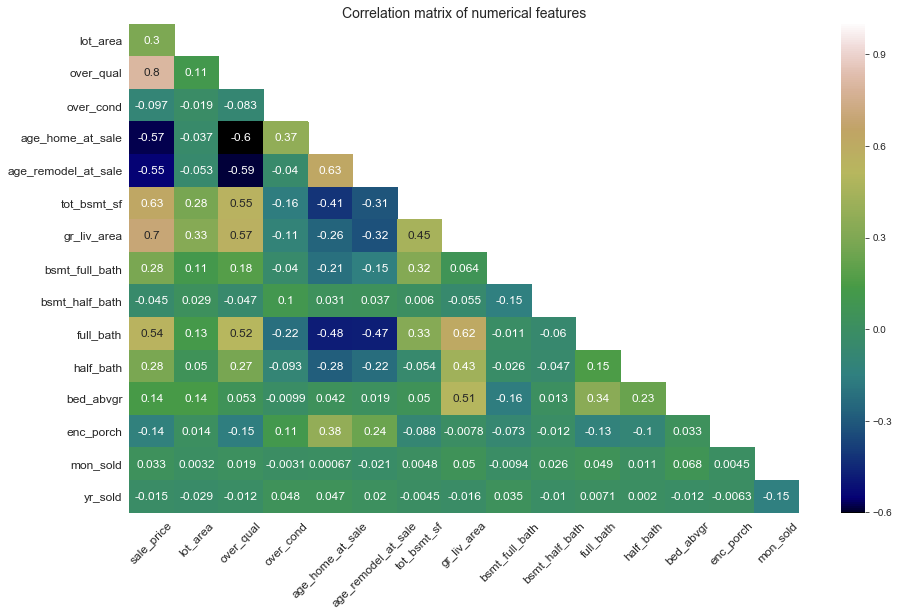

In [15]:
# View a correlation matrix of the 
df = y_trn.join(X1_trn[num_features])
c_title = "Correlation matrix of numerical features"
correl_plot(df, c_title, (15,9))

### View pairplots

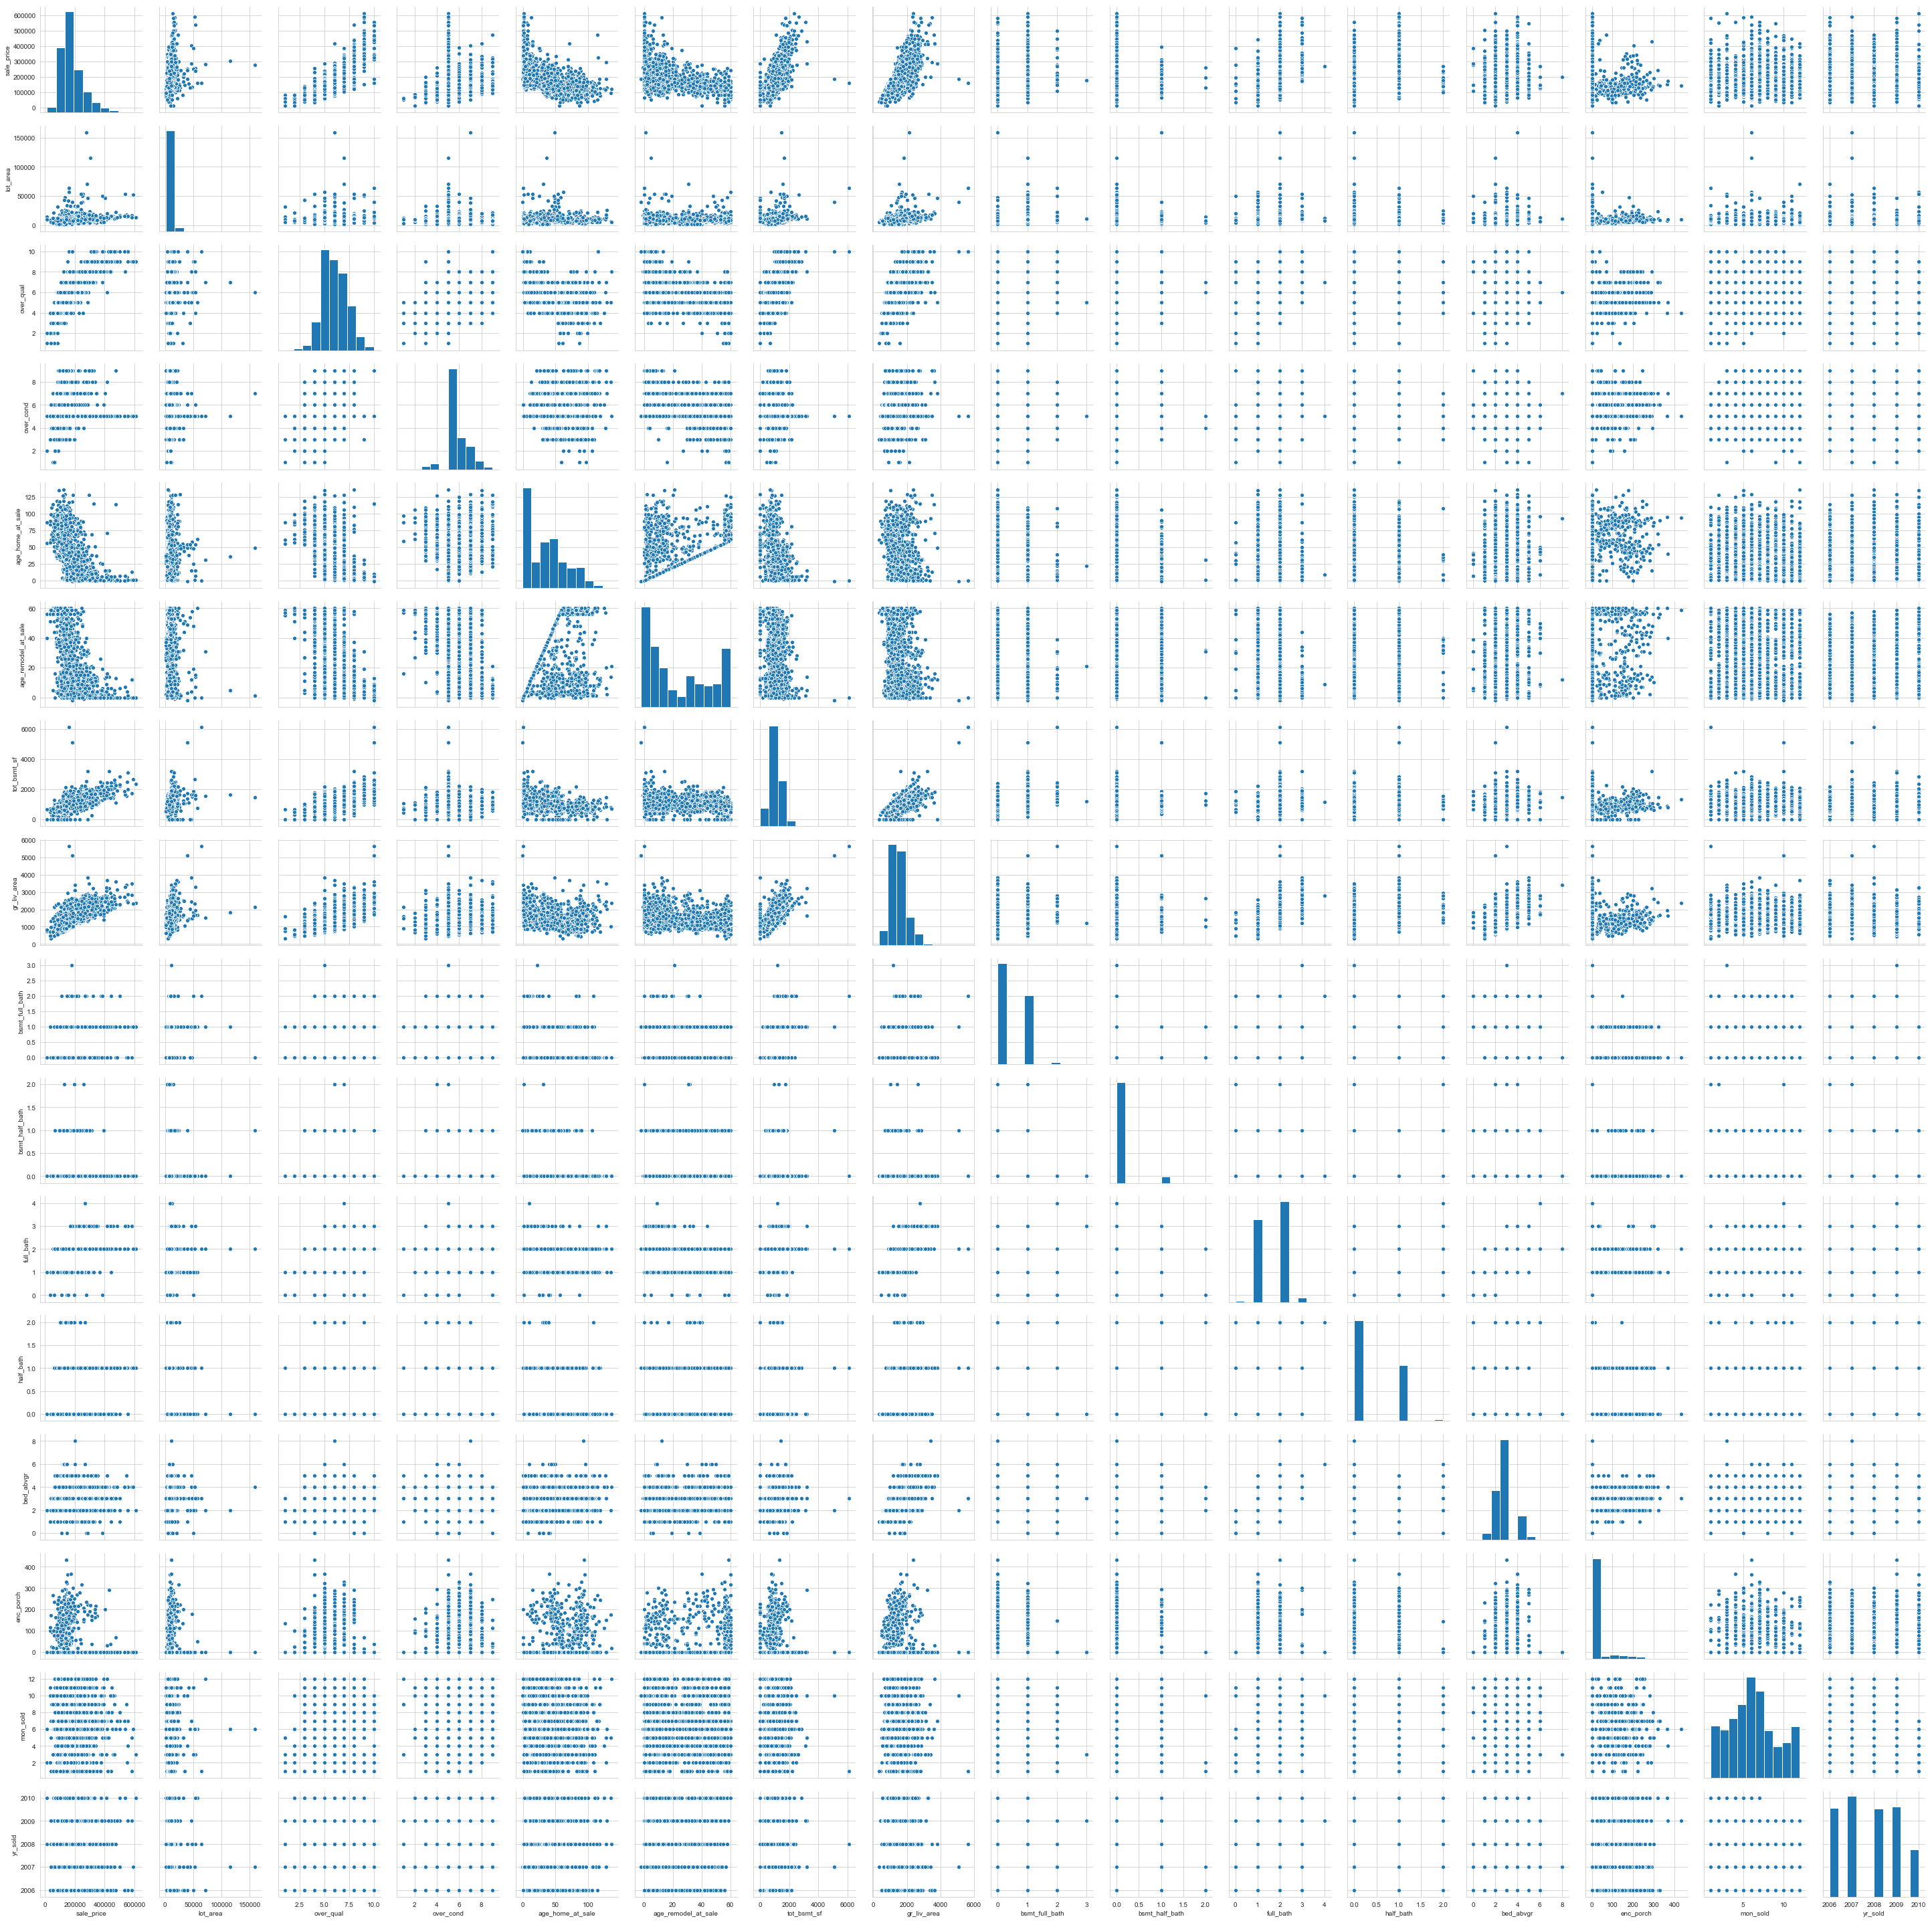

In [17]:
# 
# sns.pairplot(df)

## Numeric feature modeling


###  Use model_evaluator

In this section, we use the model_evaluator function to generate and score models of all combinations of numeric variables.  The output is stored in a dataframe.

In [157]:
df = y_trn.join(X1_trn[num_features])
var = find_most_corr(df, 'sale_price', ret_n = 7)


In [158]:
# Evaluate all the model combinations of num_features 
# Store in a dataframe for evaluation
# Create a dataframe of linear regression models
lr_num_models = model_evaluator(X1_trn_trn, y_trn_trn, var, linear_model = 'lin_regr')

# Create a dataframe of lasso regression models
# lasso_num_models = model_evaluator(X1_trn_trn, y_trn_trn, var, linear_model = 'lasso')

# Create a dataframe of ridge regression models
# ridge_num_models = model_evaluator(X1_trn_trn, y_trn_trn, var, linear_model = 'ridge')


In [160]:
# Store the variable combinations for the top models in a list
lr_top_num_models = list(lr_num_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:15])

# Store the variable combinations for the top models in a list
lasso_top_num_models = list(lr_num_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:15])

# Store the variable combinations for the top models in a list
# ridge_top_num_models = list(lr_num_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:15])


## Addition of categorical variables 

In [161]:
# For each category feature create a list of related columns
# cat_lists is a list of lists 
cat_lists = [ cat_list(X1_trn, cat) for cat in cat_features]


In [221]:
# Add the category variables 

# Evaluate adding the category vsariables to the linear regression models
lr_num_cat_models = cat_evaluator(X1_trn_trn, y_trn_trn, cat_lists, lr_top_num_models, 2, linear_model = 'line_regr')



In [222]:
lr_num_cat_models.sort_values(by ='CV R2', ascending = False).head()

,CV R2,Coeff,Combo,Intercept,Model,Pred
2430,0.825167,"[[17096.635949032843, 47.50171708118505, 26.10...","[over_qual, gr_liv_area, tot_bsmt_sf, age_home...",[-28172.99388837858],line_regr,"[[17310.65501670172], [209397.99314619348], [1..."
2190,0.825167,"[[17096.635949032843, 47.50171708118505, 26.10...","[over_qual, gr_liv_area, tot_bsmt_sf, age_home...",[-28172.99388837858],line_regr,"[[17310.65501670172], [209397.99314619348], [1..."
2340,0.825167,"[[17096.635949032843, 47.50171708118505, 26.10...","[over_qual, gr_liv_area, tot_bsmt_sf, age_home...",[-28172.99388837858],line_regr,"[[17310.65501670172], [209397.99314619348], [1..."
2310,0.825167,"[[17096.635949032843, 47.50171708118505, 26.10...","[over_qual, gr_liv_area, tot_bsmt_sf, age_home...",[-28172.99388837858],line_regr,"[[17310.65501670172], [209397.99314619348], [1..."
60,0.825167,"[[17096.635949032843, 47.50171708118505, 26.10...","[over_qual, gr_liv_area, tot_bsmt_sf, age_home...",[-28172.99388837858],line_regr,"[[17310.65501670172], [209397.99314619348], [1..."


### Pick the top performing model on the training subset of the training data

In [183]:
# Store the variable combinations for the top models in a list
lr_top_models = list(lr_num_cat_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:15])

lr_best_model = list(lr_num_cat_models.sort_values(by = 'CV R2', ascending = False)['Combo'][:1])


2430    [over_qual, gr_liv_area, tot_bsmt_sf, age_home...
Name: Combo, dtype: object

In [187]:
# Get the training R2 for this model
R2 = lr_num_cat_models.sort_values(by = 'CV R2', ascending = False)['CV R2'][:1]
R2

# lr_num_cat_models[lr_num_cat_models['Combo']==lr_best_model]
# lr_num_cat_models.loc[2430,'Combo']

2430    0.825167
Name: CV R2, dtype: float64

## Test the model on training test set

In [196]:
# Examine a single model selected from the procedure above
features = lr_best_model

lr = LinearRegression()
model_lr = lr.fit(X1_trn_trn, y_trn_trn)
pred_lr_trn_tst = lr.predict(X1_trn_tst)

r2_score(y_trn_tst, pred_lr_trn_tst)

0.7663139969901407

### Train the model on the entire training data set


In [197]:
# Retrain the model using the entire training set
model_lr = lr.fit(X1_trn, y_trn)
pred_lr_trn = lr.predict(X1_trn)

r2_score(y_trn, pred_lr_trn)

0.8964160067824245

### Create predictions on the test data set

In [202]:
# Create test predictions
pred_lr_tst = pd.DataFrame(lr.predict(X1_tst))

### Write to a file 


In [219]:
# Open the test file to get the ID
df = pd.DataFrame(pred_lr_tst)

test_file_name = "test.csv"
a_tst = pd.read_csv(os.path.join(data_path, test_file_name))

pred_out = a_tst[['Id']].join(df).sort_values(by='Id')

pred_out.head()

,Id,0
704,2,118553.014731
706,4,284073.285259
120,6,177034.415734
312,7,243899.124464
401,17,204333.467147


In [220]:

# Save the y data to csv file
pred_dataframe_name = "pred_1_Steve_Godfrey.csv"

pred_out.to_csv(os.path.join(data_path, pred_dataframe_name), header = ['Id','SalePrice'], index = False)
